In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import networkx as nx
import heapq
import time
from utils_discrete import GraphConstructionDiscretization, biobjective_search, extract_costs, check_pareto_optimality, plot_costs

In [2]:
# =============================================================================
# Constants, UAV parameters, and initial conditions
# =============================================================================
# Define QZ circles as tuples (x, y, radius, only_electric_radius, risk_limit, toggle_only_electric_or_no_path) toggle_only_electric_or_no_path = 0 for no path, 1 for only electric
map_qz = [(0.0, 0.0, 6.0, 2.0, 30, 1), (12.0, 10.0, 4.0, 1.5, 30, 1)]
max_risk_limit = 2 / 3 * sum([circle[-2] for circle in map_qz])
acceptable_risk_limit = 1 / 3 * sum([circle[-2] for circle in map_qz])
max_risk_limit = 200
acceptable_risk_limit = 0
start = (-5, -5)       # Starting point
goal = (15, 15)        # Goal point

# UAV characteristics
alpha = 0.5
recharge_factor = 2
beta = alpha / recharge_factor

q_min, q_max, q_act = 20, 100, 50
discretization_angle = 10

# Risk limits (temporary) and an index map for circles
# risk_limit = {circle: 30 for circle in map_qz}

The time req for grap construction: 0.5975911617279053
The time req for biobjective_search: 6.704094409942627
Dominated solution indices: []


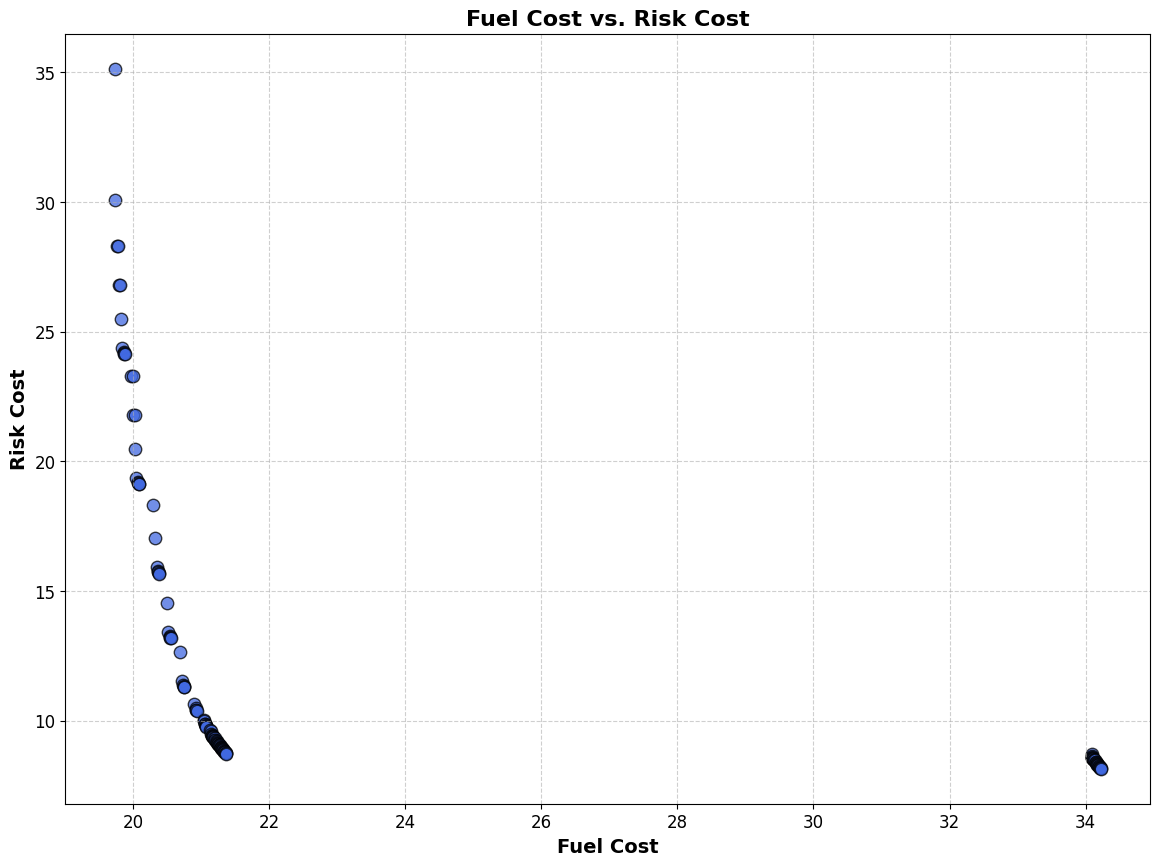

In [3]:
# =============================================================================
# Graph Construction and Node Creation
# =============================================================================

# Instantiate the graph construction object.
# (Assuming you have already refactored your class into GraphConstructionDiscretization.)
graph_object = GraphConstructionDiscretization(
    map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle, max_risk_limit, acceptable_risk_limit
)

start_time = time.time()
# Create nodes and the index maps.
nodes, index_map, reverse_index_map = graph_object.create_nodes()

# Build the visibility graph
graph_object.build_visibility_graph(reverse_index_map)
end_time = time.time()

print(f"The time req for grap construction: {end_time-start_time}")
# Assign heuristic cost to each node
graph_object.assign_heuristic_costs(reverse_index_map)

# Run the biobjective search
start_state = "s"
goal_state = "g"

start_time = time.time()
sols, g2_min = biobjective_search(graph_object, start_state, goal_state, reduce_factor=1)
end_time = time.time()
print(f"The time req for biobjective_search: {end_time-start_time}")
# =============================================================================
# Pareto Optimality Check and Plotting
# =============================================================================

# Extract cost values for the goal state
fuel_costs, risk_costs = extract_costs(sols, goal_state)

# Check Pareto optimality
dominated_indices = check_pareto_optimality(fuel_costs, risk_costs)
print("Dominated solution indices:", dominated_indices)

# Plot the results
plot_costs(fuel_costs, risk_costs)

# # Reconstruct and print all solution paths
# solution_paths = reconstruct_solution_paths(sols, start_state, goal_state)
# print("Extracted Solution Paths:")
# for spath in solution_paths:
#     print(spath)

# =============================================================================
# End of Pipeline
# =============================================================================

In [5]:
##### Doing a single objective search with weigth objective
scale_fuel_cost = 40
scale_risk_cost = 60

# =============================================================================
# Graph Construction and Node Creation
# =============================================================================

# Instantiate the graph construction object.
# (Assuming you have already refactored your class into GraphConstructionDiscretization.)
graph_object = GraphConstructionDiscretization(
    map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle, max_risk_limit, acceptable_risk_limit
)

start_time = time.time()
# Create nodes and the index maps.
nodes, index_map, reverse_index_map = graph_object.create_nodes()

# Build the visibility graph
graph_object.build_visibility_graph(reverse_index_map)
end_time = time.time()

print(f"The time req for grap construction: {end_time-start_time}")
# Assign heuristic cost to each node
graph_object.assign_heuristic_costs(reverse_index_map)

def heuristic(n1,n2):
    return graph_object.visibility_graph.nodes[n1]['heuristic_cost']

# Run the biobjective search
start_state = "s"
goal_state = "g"
path_cost_fuel_list = []
path_cost_risk_list = []
for factor in np.arange(0,1,0.01):
    for edge_1, edge_2 in graph_object.visibility_graph.edges:
        graph_object.visibility_graph[edge_1][edge_2]['weight'] = factor*graph_object.visibility_graph[edge_1][edge_2]['fuel_cost'] + (1-factor)*graph_object.visibility_graph[edge_1][edge_2]['risk_cost']

    path = nx.astar_path(graph_object.visibility_graph, source=start_state, target=goal_state, heuristic=heuristic, weight='weight')
    print(path)
    path_cost_fuel = sum([graph_object.visibility_graph[path[i]][path[i+1]]['fuel_cost'] for i in range(len(path)-1)])
    path_cost_risk = sum([graph_object.visibility_graph[path[i]][path[i+1]]['risk_cost'] for i in range(len(path)-1)])
    
    path_cost_fuel_list.append(path_cost_fuel)
    path_cost_risk_list.append(path_cost_risk)
    print(f"factor: {factor}, path_cost_fuel: {path_cost_fuel}, path_cost_risk: {path_cost_risk}")

The time req for grap construction: 0.4026472568511963
['s', 27, 28, 29, 30, 31, 35, 70, 71, 72, 73, 74, 39, 40, 41, 'g']
factor: 0.0, path_cost_fuel: 22.370335590267, path_cost_risk: 10.9255417668680
['s', 27, 28, 29, 30, 31, 35, 70, 71, 72, 73, 74, 39, 40, 41, 'g']
factor: 0.01, path_cost_fuel: 22.370335590267, path_cost_risk: 10.9255417668680
['s', 27, 28, 29, 30, 31, 35, 70, 71, 72, 73, 74, 39, 40, 41, 'g']
factor: 0.02, path_cost_fuel: 22.370335590267, path_cost_risk: 10.9255417668680
['s', 27, 28, 29, 30, 31, 35, 70, 71, 72, 73, 74, 39, 40, 41, 'g']
factor: 0.03, path_cost_fuel: 22.370335590267, path_cost_risk: 10.9255417668680
['s', 22, 21, 20, 19, 18, 14, 12, 11, 53, 52, 51, 50, 49, 'g']
factor: 0.04, path_cost_fuel: 21.438806391173603, path_cost_risk: 10.0717951671836
['s', 22, 21, 20, 19, 18, 14, 12, 11, 53, 52, 51, 50, 49, 'g']
factor: 0.05, path_cost_fuel: 21.438806391173603, path_cost_risk: 10.0717951671836
['s', 22, 21, 20, 19, 18, 14, 12, 11, 53, 52, 51, 50, 49, 'g']
fac

In [6]:
dominated_indices = check_pareto_optimality(path_cost_fuel_list, path_cost_risk_list)

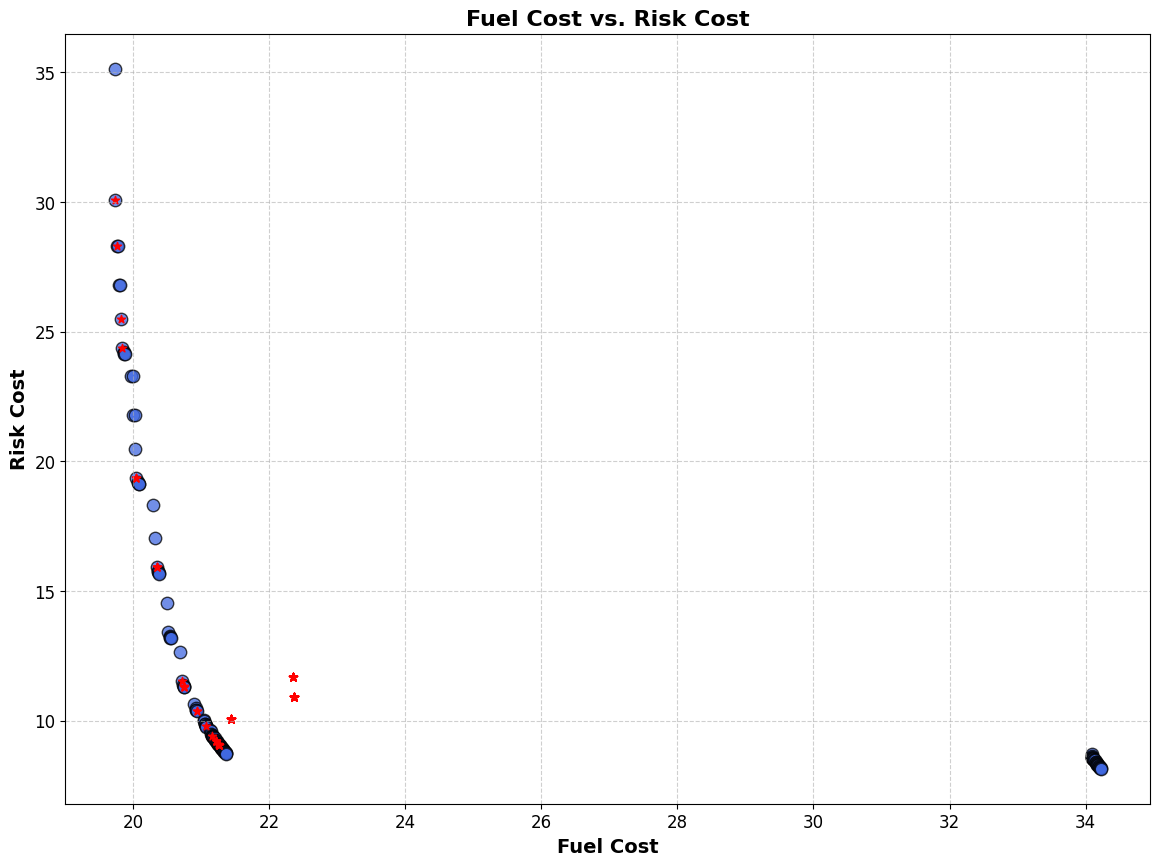

In [9]:
plt.figure(figsize=(14, 10))
plt.scatter(fuel_costs, risk_costs, color='royalblue', edgecolors='black',
            alpha=0.75, s=80)
plt.scatter(path_cost_fuel_list, path_cost_risk_list, color='red', marker='*')
plt.xlabel("Fuel Cost", fontsize=14, fontweight='bold')
plt.ylabel("Risk Cost", fontsize=14, fontweight='bold')
plt.title("Fuel Cost vs. Risk Cost", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# import random
# ##### Plotting the solution path for which passes thru certain state
# plt.figure(figsize=(14, 10))
# random.seed(42)
# colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(len(paths_with_22_xy))]

# for i, path in enumerate(paths_with_22_xy):
#     x, y = zip(*path)
#     plt.plot(x, y, marker='o', linestyle='-', color=colors[i], label=f'{float(paths_with_22[i][-1][0]):.2f},{float(paths_with_22[i][-1][1]):.2f}')

# for x_c, y_c, r in Map_qz:
#     circle = plt.Circle((x_c, y_c), r, color='gray', alpha=0.3, fill=True)
#     plt.gca().add_patch(circle)

# ### Start and goal points
# plt.scatter(start[0], start[0], color='black', marker='s', s=100, label='Start' )
# plt.scatter(goal[0], goal[0], color='red', marker='*', s=150, label='Goal')

# # Formatting
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend()
# plt.axis("equal")  # Ensure aspect ratio is equal
# plt.grid(True)
# plt.title("Paths with Circles and Start/Goal Points")
# plt.show()